In [1]:
import os
os.chdir('../')

In [2]:
%matplotlib inline
#%matplotlib notebook

%load_ext autoreload
%autoreload 2

In [3]:
from copy import deepcopy
from decimal import Decimal
from typing import List, Tuple
from warnings import warn

from cycler import cycler
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.decomposition import PCA
import scipy.stats as stats
import torch
from torch import nn
import torch.nn.functional as F
import seml
from ogb.nodeproppred import PygNodePropPredDataset

from torch_geometric.utils import subgraph
from rgnn_at_scale.utils import accuracy

import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False

import tqdm
tqdm.tqdm.pandas()

/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
from notebooks import mpl_latex

/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [5]:
#mpl_latex.enable_production_mode()

In [6]:
df_experiments = seml.get_results('kdd21_rgnn_at_scale_attack_evasion_transfer_vs_number_nodes',
                                  to_data_frame=True,
                                  fields=['batch_id', 'slurm', 'config', 'result'])

df_experiments = df_experiments[df_experiments['config.use_largest_component'].fillna(False)]

df_experiments.head()

/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/site-packages/seml/evaluation.py:48: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  parsed = pd.io.json.json_normalize(parsed, sep='.')


,_id,batch_id,slurm.experiments_per_job,slurm.sbatch_options.gres,slurm.sbatch_options.mem,slurm.sbatch_options.cpus-per-task,slurm.sbatch_options.time,slurm.sbatch_options.nodes,slurm.sbatch_options.job-name,slurm.sbatch_options.array,...,config.seed,config.artifact_dir,config.pert_adj_storage_type,config.pert_attr_storage_type,config.device,config.display_steps,config.model_label,config.n_classes,result.results,config.use_largest_component
200,201,2,1,gpu:1,16G,4,0-01:00,1,rgnn_at_scale_attack_evasion_transfer_vs_numbe...,0-999,...,0,cache,evasion_transfer_attack_vs_number_nodes_adj,evasion_transfer_attack_vs_number_nodes_attr,0,10,None,8,"[{'label': 'Surrogate', 'epsilon': 0, 'accurac...",True
202,203,2,1,gpu:1,16G,4,0-01:00,1,rgnn_at_scale_attack_evasion_transfer_vs_numbe...,0-999,...,1,cache,evasion_transfer_attack_vs_number_nodes_adj,evasion_transfer_attack_vs_number_nodes_attr,0,10,None,8,"[{'label': 'Surrogate', 'epsilon': 0, 'accurac...",True
204,205,2,1,gpu:1,16G,4,0-01:00,1,rgnn_at_scale_attack_evasion_transfer_vs_numbe...,0-999,...,2,cache,evasion_transfer_attack_vs_number_nodes_adj,evasion_transfer_attack_vs_number_nodes_attr,0,10,None,8,"[{'label': 'Surrogate', 'epsilon': 0, 'accurac...",True
206,207,2,1,gpu:1,16G,4,0-01:00,1,rgnn_at_scale_attack_evasion_transfer_vs_numbe...,0-999,...,3,cache,evasion_transfer_attack_vs_number_nodes_adj,evasion_transfer_attack_vs_number_nodes_attr,0,10,None,8,"[{'label': 'Surrogate', 'epsilon': 0, 'accurac...",True
208,209,2,1,gpu:1,16G,4,0-01:00,1,rgnn_at_scale_attack_evasion_transfer_vs_numbe...,0-999,...,4,cache,evasion_transfer_attack_vs_number_nodes_adj,evasion_transfer_attack_vs_number_nodes_attr,0,10,None,8,"[{'label': 'Surrogate', 'epsilon': 0, 'accurac...",True


In [7]:
df_experiments.columns

Index(['_id', 'batch_id', 'slurm.experiments_per_job',
       'slurm.sbatch_options.gres', 'slurm.sbatch_options.mem',
       'slurm.sbatch_options.cpus-per-task', 'slurm.sbatch_options.time',
       'slurm.sbatch_options.nodes', 'slurm.sbatch_options.job-name',
       'slurm.sbatch_options.array', 'slurm.sbatch_options.output',
       'slurm.array_id', 'slurm.task_id', 'config.overwrite',
       'config.db_collection', 'config.dataset', 'config.attack',
       'config.attack_params.do_synchronize',
       'config.attack_params.keep_heuristic', 'config.attack_params.loss_type',
       'config.attack_params.search_space_size', 'config.epsilons',
       'config.surrogate_params.n_filters', 'config.surrogate_params.dropout',
       'config.surrogate_params.train_params.lr',
       'config.surrogate_params.train_params.weight_decay',
       'config.surrogate_params.train_params.patience',
       'config.surrogate_params.train_params.max_epochs', 'config.binary_attr',
       'config.seed', 

In [8]:
df_results = [
    pd.DataFrame(r) 
    for r in df_experiments['result.results']
]
for df_result, (_, df_experiment) in zip(df_results, df_experiments.iterrows()):
    df_result['dataset'] = df_experiment['config.dataset']
    df_result['attack'] = df_experiment['config.attack']
    df_result['block_size'] = df_experiment['config.attack_params.search_space_size']
    df_result['seed'] = df_experiment['config.seed']
    df_result['novel_loss'] = (
        (df_experiment['config.attack_params.loss_type'] == 'MCE')
        | (df_experiment['config.attack_params.loss_type'] == 'tanhCW')
    )


df_results = pd.concat(df_results, ignore_index=True)
df_results

,label,epsilon,accuracy,labels,n_nodes,n_nodes_largest_component,average_degree,average_degree_largest_component,n_classes,n_classes_largest_component,label_count,label_count_largest_component,sparsity,label_count_train,dataset,attack,block_size,seed,novel_loss
0,Surrogate,0.00,0.944869,"[4, 5, 11, 14, 16, 21, 29, 39]",42326,38990,16.264944,17.571018,40,8,"[5862, 27321, 393, 4958, 750, 597, 2029, 416]","[5228, 26606, 199, 4222, 469, 543, 1429, 294]",0.000384,"[2525, 9553, 151, 2467, 251, 434, 1117, 155]",ogbn-arxiv,PRBCD,5000000,0,True
1,Surrogate,0.01,0.838570,"[4, 5, 11, 14, 16, 21, 29, 39]",42326,38990,16.264944,17.571018,40,8,"[4, 5, 11, 14, 16, 21, 29, 39]","[5862, 27321, 393, 4958, 750, 597, 2029, 416]",0.000384,"[5228, 26606, 199, 4222, 469, 543, 1429, 294]",ogbn-arxiv,PRBCD,5000000,0,True
2,Surrogate,0.05,0.692850,"[4, 5, 11, 14, 16, 21, 29, 39]",42326,38990,16.264944,17.571018,40,8,"[4, 5, 11, 14, 16, 21, 29, 39]","[5862, 27321, 393, 4958, 750, 597, 2029, 416]",0.000384,"[5228, 26606, 199, 4222, 469, 543, 1429, 294]",ogbn-arxiv,PRBCD,5000000,0,True
3,Surrogate,0.10,0.624651,"[4, 5, 11, 14, 16, 21, 29, 39]",42326,38990,16.264944,17.571018,40,8,"[4, 5, 11, 14, 16, 21, 29, 39]","[5862, 27321, 393, 4958, 750, 597, 2029, 416]",0.000384,"[5228, 26606, 199, 4222, 469, 543, 1429, 294]",ogbn-arxiv,PRBCD,5000000,0,True
4,Surrogate,0.25,0.573704,"[4, 5, 11, 14, 16, 21, 29, 39]",42326,38990,16.264944,17.571018,40,8,"[4, 5, 11, 14, 16, 21, 29, 39]","[5862, 27321, 393, 4958, 750, 597, 2029, 416]",0.000384,"[5228, 26606, 199, 4222, 469, 543, 1429, 294]",ogbn-arxiv,PRBCD,5000000,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2490,Surrogate,0.00,0.949056,"[0, 3, 18, 22, 24, 36, 38, 39]",34544,30757,8.845125,9.811067,40,8,"[2029, 1507, 565, 2080, 749, 22187, 1903, 3524]","[1458, 1401, 415, 1434, 655, 20642, 1550, 3202]",0.000256,"[1142, 1030, 318, 676, 349, 6344, 1016, 2273]",ogbn-arxiv,PRBCD,5000000,499,True
2491,Surrogate,0.01,0.876243,"[0, 3, 18, 22, 24, 36, 38, 39]",34544,30757,8.845125,9.811067,40,8,"[0, 3, 18, 22, 24, 36, 38, 39]","[2029, 1507, 565, 2080, 749, 22187, 1903, 3524]",0.000256,"[1458, 1401, 415, 1434, 655, 20642, 1550, 3202]",ogbn-arxiv,PRBCD,5000000,499,True
2492,Surrogate,0.05,0.771620,"[0, 3, 18, 22, 24, 36, 38, 39]",34544,30757,8.845125,9.811067,40,8,"[0, 3, 18, 22, 24, 36, 38, 39]","[2029, 1507, 565, 2080, 749, 22187, 1903, 3524]",0.000256,"[1458, 1401, 415, 1434, 655, 20642, 1550, 3202]",ogbn-arxiv,PRBCD,5000000,499,True
2493,Surrogate,0.10,0.699718,"[0, 3, 18, 22, 24, 36, 38, 39]",34544,30757,8.845125,9.811067,40,8,"[0, 3, 18, 22, 24, 36, 38, 39]","[2029, 1507, 565, 2080, 749, 22187, 1903, 3524]",0.000256,"[1458, 1401, 415, 1434, 655, 20642, 1550, 3202]",ogbn-arxiv,PRBCD,5000000,499,True


/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]
/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
No handles with labels found to put in legend.
/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will

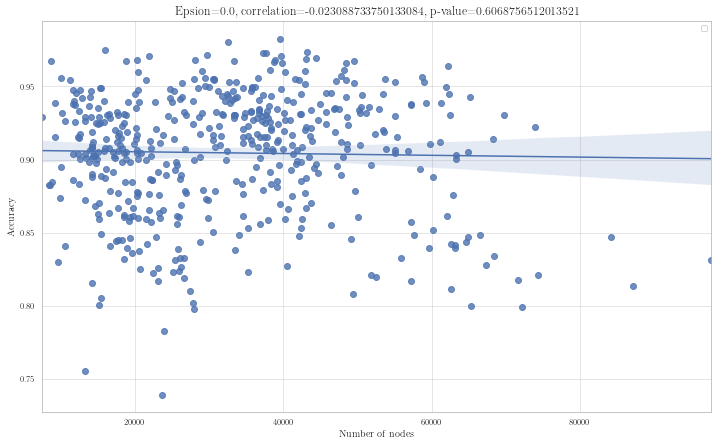

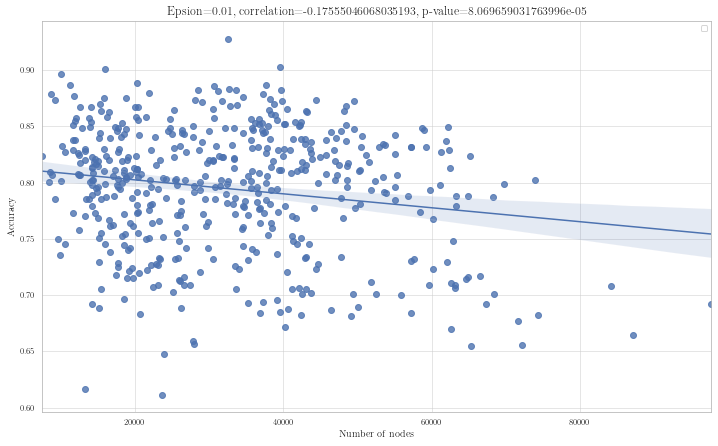

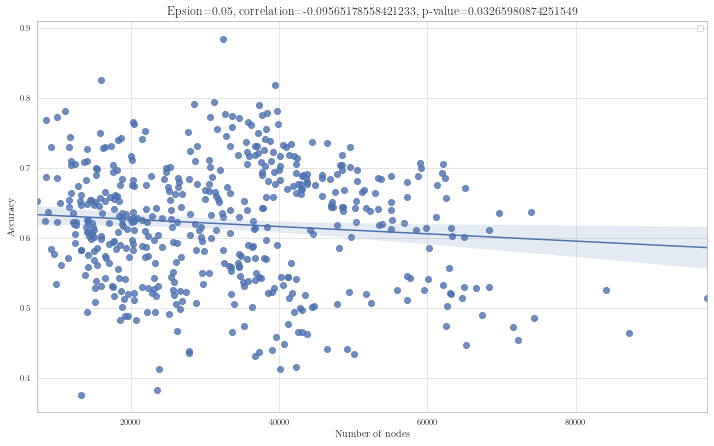

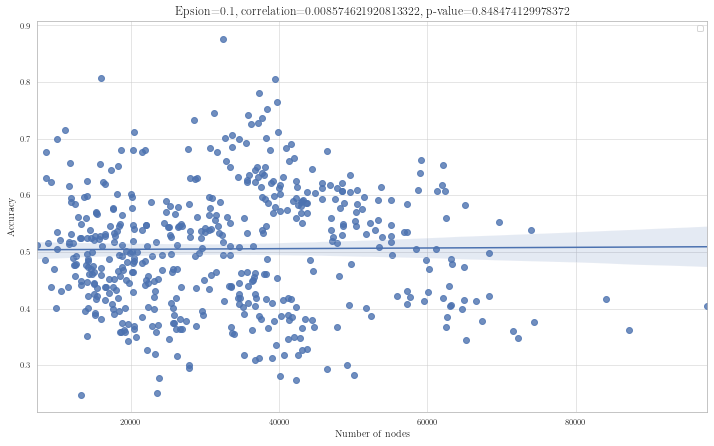

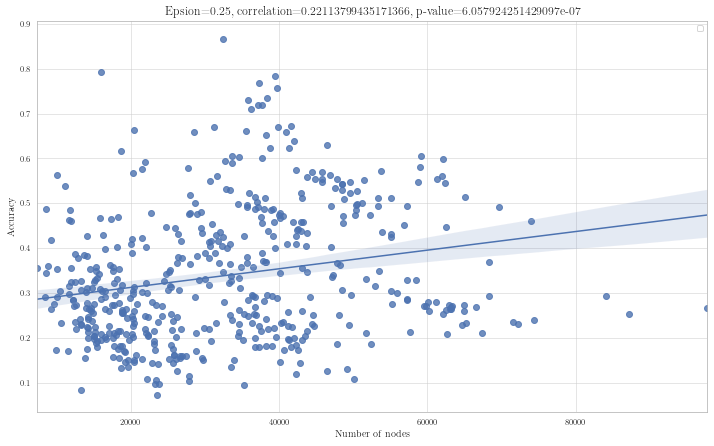

In [9]:
for epsilon in np.unique(df_results.epsilon):
    df = df_results[df_results.epsilon == epsilon]
    fig, ax = mpl_latex.newfig(width=0.30, ratio_yx=0.6)
    #plt.scatter(df.n_nodes, df.accuracy)
    sns.regplot(df.n_nodes, df.accuracy)
    plt.xlabel('Number of nodes')
    plt.ylabel('Accuracy')
    correlation, p_value = stats.pearsonr(df.n_nodes, df.accuracy)
    plt.title(f'Epsion={epsilon}, correlation={correlation}, p-value={p_value}')
    mpl_latex.savefig(f'latex/assets/global_prbcd_arxiv_{epsilon}_graph_size_vs_robustness_no_legend', fig, close_fig=False)
    plt.legend()
    mpl_latex.savefig(f'latex/assets/global_prbcd_arxiv_{epsilon}_graph_size_vs_robustness', fig, close_fig=False)
    mpl_latex.dedicated_legend_plot(
        f'latex/assets/global_prbcd_arxiv_{epsilon}_graph_size_vs_robustness_legend',
        mod_label=lambda l: l,
        ncol=3
    )

/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]
/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
No handles with labels found to put i

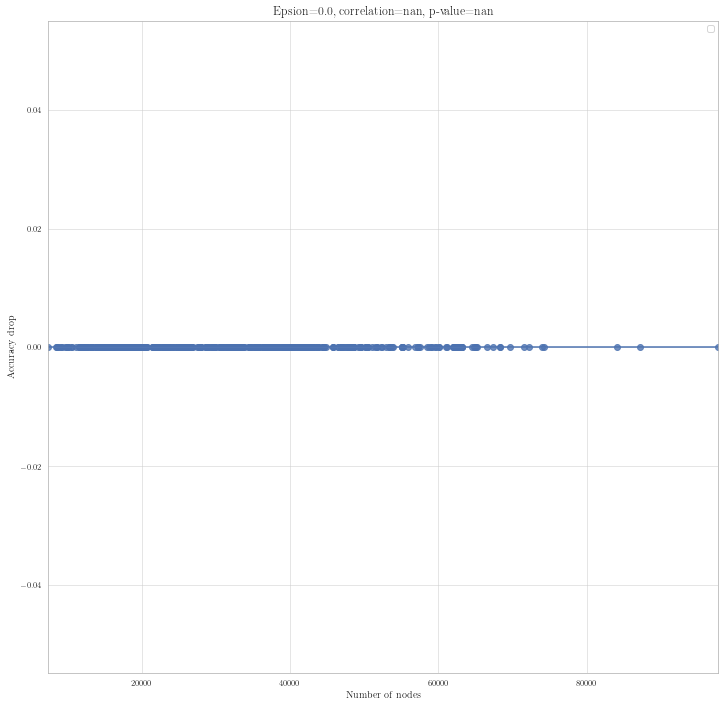

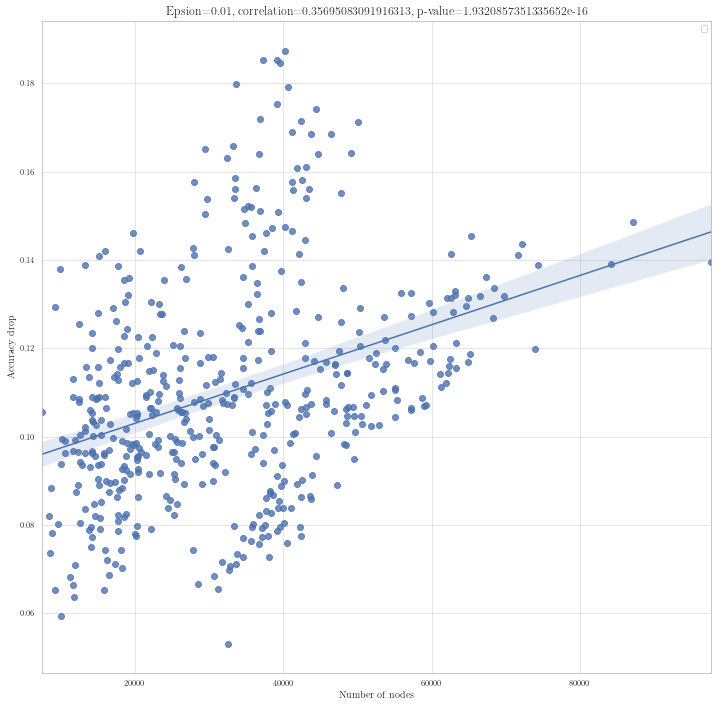

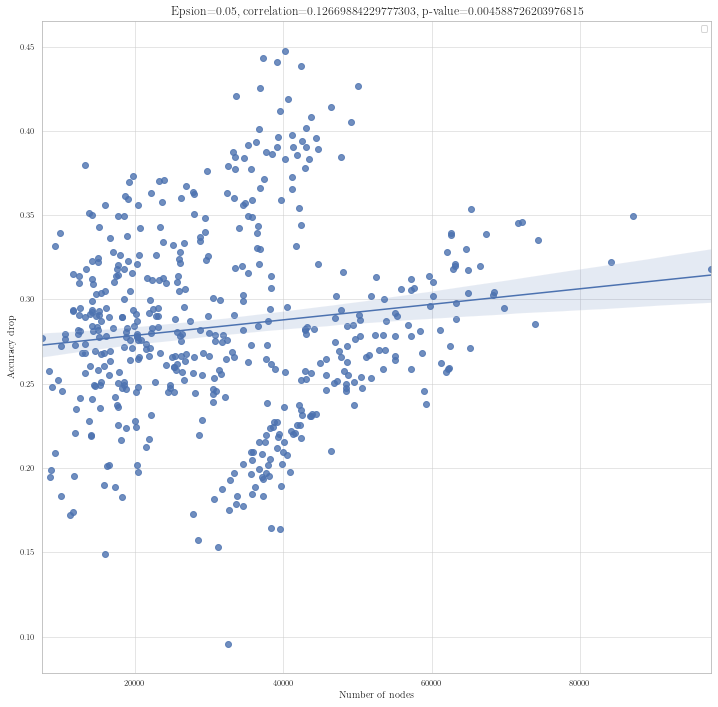

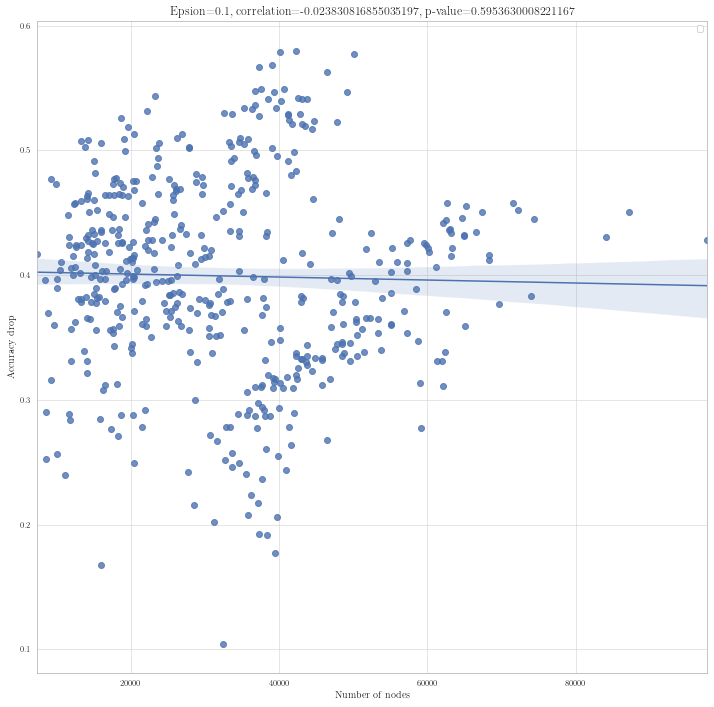

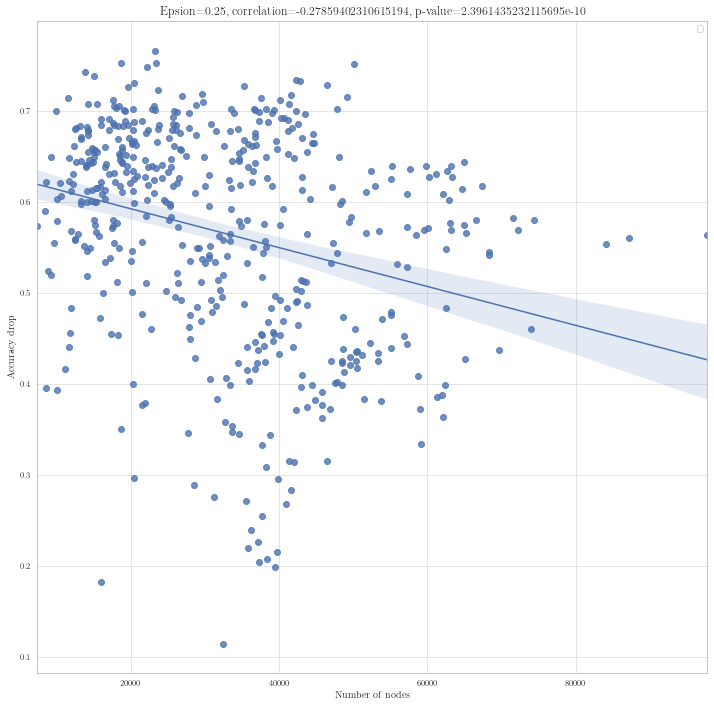

In [10]:
for epsilon in np.unique(df_results.epsilon):
    df = df_results[df_results.epsilon == epsilon]
    df = df.merge(df_results[df_results.epsilon == 0], on='seed', suffixes=('', '_zero_eps'))
    #df = df[(df.accuracy_zero_eps - df.accuracy) <= 0.15]
    fig, ax = mpl_latex.newfig(width=0.30, ratio_yx=1)
    #plt.scatter(df.n_nodes, df.accuracy)
    sns.regplot(df.n_nodes, df.accuracy_zero_eps - df.accuracy)
    plt.xlabel('Number of nodes')
    plt.ylabel('Accuracy drop')
    correlation, p_value = stats.pearsonr(df.n_nodes, df.accuracy_zero_eps - df.accuracy)
    plt.title(f'Epsion={epsilon}, correlation={correlation}, p-value={p_value}')
    mpl_latex.savefig(f'latex/assets/global_prbcd_arxiv_{epsilon}_graph_size_vs_robustness_drop_no_legend', fig, close_fig=False)
    plt.legend()
    mpl_latex.savefig(f'latex/assets/global_prbcd_arxiv_{epsilon}_graph_size_vs_robustness_drop', fig, close_fig=False)
    mpl_latex.dedicated_legend_plot(
        f'latex/assets/global_prbcd_arxiv_{epsilon}_graph_size_vs_robustness_drop_legend',
        mod_label=lambda l: l,
        ncol=3
    )

In [11]:
'q'/2

import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

for epsilon in np.unique(df_results.epsilon):
    df = df_results[df_results.epsilon == epsilon]
    df = df.merge(df_results[df_results.epsilon == 0], on='seed', suffixes=('', '_zero_eps'))
    fig, ax = mpl_latex.newfig(width=0.30, ratio_yx=0.6)
    results = smf.ols('accuracy_zero_eps ~ n_nodes', data=df).fit()
    sm.graphics.influence_plot(results)
    plt.xlabel('Number of nodes')
    plt.ylabel('Accuracy drop')
    plt.title(f'Epsion={epsilon}, correlation={correlation}, p-value={p_value}')

    


TypeError: unsupported operand type(s) for /: 'str' and 'int'